# COBRApy

COBRApy is a package for constraint-based modeling of biological networks written in Python.

This tool allows loading and inspecting Genome-Scale Metabolic (GEM) models written in the Systems Biology Markup Language (SBML) format.

Using COBRApy, one can analyse the following model contents:
1. Reactions
2. Metabolites
3. Genes
4. Exchange reactions (Environmental Conditions)

COBRApy allows manipulating the contents of a GEM model. For instance, one can edit reactions' flux bounds, knock out a metabolic gene, or change the environmental conditions.

Phenotype prediction can be simulated with several flux analysis methods implemented in COBRApy. These include Flux Balance Analysis (FBA), Parsimonious FBA, or Flux Variability Analysis (FVA).

The simulation of gene and reaction deletions for a given GEM model is a simple and straightforward process. One can simulate single or double knock outs using one of the flux analysis methods mentioned above.

## Instalation


### Requirements
The following requirements need to be installed to use COBRApy:
- Python 3.6 or higher
- pip must be installed
- GLPK solver is used by default but CPLEX is prefered


### How to install COBRApy?
```
pip install cobra
```

# Exercise 5 - Phenotype prediction

## Working with a GEM model

For this practical session, we will be using the following model:
- _E. coli_ core model which contains the central carbon metabolism of _Escherichia coli_ -> file: ../data/e_coli_core.xml

You can read more about _E. coli_ core model (Orth et al 2010) in the following links:
- https://journals.asm.org/doi/10.1128/ecosalplus.10.2.1
- http://bigg.ucsd.edu/models/e_coli_core

This exercise consists of exploring the phenotype prediction tools of COBRApy. Thus, the following steps will be followed:
- Loading the model with COBRApy;
- Perform a FBA simulation using an aerobic/anaerobic conditions;
- Perform reaction and gene deletions;
- Perform other flux analysis methods, such as pFBA, FVA, ROOM and MOMA;
- Analyzing the model essential reactions and genes;

In [1]:
# importing cobra
import cobra

# Loading a model
model_path = '../data/e_coli_core.xml'
model = cobra.io.read_sbml_model(model_path)

model

Name,e_coli_core
Memory address,0x02738a8854c8
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


## Phenotype Prediction

COBRApy includes different algorithms for phenotype prediction. These include:
- Flux Balance Analysis (FBA); 
- Parsimonious Flux Balance Analysis (pFBA);
- Flux Variability Analysis (FVA);
- Regulatory On/Off Minimization (ROOM);
- Minimization of Metabolic Adjustment (MOMA);

### Flux Balance Analysis (FBA) - Aerobiosis

First, the exchange reactions should be verified to make sure that the aerobic conditions are all set up in the model.

In [2]:
#inspecting the exchange reactions.
for exchange in model.exchanges:
    print(exchange.name, '->', exchange.bounds)

Acetate exchange -> (0.0, 1000.0)
Acetaldehyde exchange -> (0.0, 1000.0)
2-Oxoglutarate exchange -> (0.0, 1000.0)
CO2 exchange -> (-1000.0, 1000.0)
Ethanol exchange -> (0.0, 1000.0)
Formate exchange -> (0.0, 1000.0)
D-Fructose exchange -> (0.0, 1000.0)
Fumarate exchange -> (0.0, 1000.0)
D-Glucose exchange -> (-10.0, 1000.0)
L-Glutamine exchange -> (0.0, 1000.0)
L-Glutamate exchange -> (0.0, 1000.0)
H+ exchange -> (-1000.0, 1000.0)
H2O exchange -> (-1000.0, 1000.0)
D-lactate exchange -> (0.0, 1000.0)
L-Malate exchange -> (0.0, 1000.0)
Ammonia exchange -> (-1000.0, 1000.0)
O2 exchange -> (-1000.0, 1000.0)
Phosphate exchange -> (-1000.0, 1000.0)
Pyruvate exchange -> (0.0, 1000.0)
Succinate exchange -> (0.0, 1000.0)


In [3]:
# performing a FBA simulation in aerobiosis
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


### Flux Balance Analysis (FBA) - Anaerobiosis

Now, we should alter the exchange reactions to anaerobic conditions.

In [4]:
#setting an anaerobic medium
o2_exchange = model.exchanges.get_by_id('EX_o2_e')
o2_exchange.bounds = (0, 1000)
o2_exchange

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x2738b9f9488
Stoichiometry,o2_e --> O2 O2 -->
GPR,
Lower bound,0
Upper bound,1000


In [5]:
# performing a FBA simulation in anaerobiosis
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


In [7]:
# now we should revert the model changes to aerobic conditions
o2_exchange.bounds = (-1000, 1000)
o2_exchange

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x2738b9f9488
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-1000
Upper bound,1000


### Making reversible changes in the model

All changes performed in a GEM model using CORBApy are irreversible by defautl. 
That is, if we change the bounds of the oxygen exchange reaction, our model will no longer continue under aerobic conditions during this exercise.

However, there is a way to perform reversible changes in a GEM model using COBRApy. For that, one can use the `with` context manager in our `model`. All changes performed within the `with` context manager block will be reverted automatically by COBRApy.

In [8]:
# verifying that we have reverted the model changes to aerobic conditions
o2_exchange = model.exchanges.get_by_id('EX_o2_e')
o2_exchange

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x2738b9f9488
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-1000
Upper bound,1000


In [9]:
# making reversible changes in the model
with model:
    o2_exchange.bounds = (0, 1000)
    model_summary = model.summary()

model_summary

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


In [10]:
# the bounds of the oxygen exchange reaction have been reverted automatically this time
o2_exchange

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x2738b9f9488
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-1000
Upper bound,1000


### Flux Variability Analysis (FVA)

FBA can only obtain an unique flux distribution for a given objective function. Nevertheless, the space of flux distributions is very large and can vary significantly for a different objective. _FVA_ is a simulation method that finds the possible flux range for each reaction. _FVA_ can be used from the flux analysis package `cobra.flux_analysis.flux_variability_analysis(model)`. Note that, _FVA_ allows setting a minimum value of growth rate. In this case, we will be using 10% (that is, 0.1) of the wild-type growth rate.

In [11]:
#performing fva simulation
fva_solution = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.1)
fva_solution

,minimum,maximum
PFK,0.000000,160.068737
PFL,0.000000,37.765356
PGI,-46.033227,9.982085
PGK,-19.767685,-1.095915
PGL,0.000000,56.015311
...,...,...
NADH16,0.000000,112.359899
NADTRHD,0.000000,341.373936
NH4t,0.476532,9.812417
O2t,0.000000,56.179949


In [12]:
# maximum theoretical production rates of Acetate (EX_ac_e), Ethanol (EX_etoh_e), and Formate (EX_for_e)

print(f'Maximum theoretical production rate of Acetate:', fva_solution.loc['EX_ac_e', 'maximum'], 'mmol/gDW/h')
print(f'Maximum theoretical production rate of Ethanol:', fva_solution.loc['EX_etoh_e', 'maximum'], 'mmol/gDW/h')
print(f'Maximum theoretical production rate of Formate:', fva_solution.loc['EX_for_e', 'maximum'], 'mmol/gDW/h')

Maximum theoretical production rate of Acetate: 18.671770397634035 mmol/gDW/h
Maximum theoretical production rate of Ethanol: 18.671770397634035 mmol/gDW/h
Maximum theoretical production rate of Formate: 37.76535648903652 mmol/gDW/h


### Parsimonious Flux Balance Analysis (pFBA)

pFBA simulations gives the optimal growth rate, while minimizing the total sum of fluxes.
pFBA can be used from the flux analysis package `cobra.flux_analysis.pfba(model)`.

In [13]:
#performing pfba simulation
pfba_solution = cobra.flux_analysis.pfba(model)
pfba_solution

,fluxes,reduced_costs
PFK,7.477382,-2.000000
PFL,0.000000,5.733333
PGI,4.860861,-2.000000
PGK,-16.023526,2.000000
PGL,4.959985,-2.000000
...,...,...
NADH16,38.534610,-2.000000
NADTRHD,0.000000,1.422222
NH4t,4.765319,-2.000000
O2t,21.799493,-2.000000


The optimal solution of the pFBA is considerably different from the FBA result. This happens because the objective value for the pFBA is defined as the sum of all flux values (`sum(abs(pfba_solution.fluxes.values))`). On the other hand the FBA result corresponds to the flux value of the reaction that is being optimized (`fba_solution.fluxes["BIOMASS_Ecoli_core_w_GAM"]`).

In [14]:
#calculating the objective value of a pFBA solution
sum(abs(pfba_solution.fluxes.values))

518.4220855176067

### Simulating Deletions

As previously mentioned, COBRApy can be used to simulate gene or reaction deletions. The function `knock_out()` can be used to knock out a given reaction or gene.

In [17]:
#knock out the SUCDi reaction
with model:
    model.reactions.SUCDi.knock_out()
    pfba_solution = cobra.flux_analysis.pfba(model)
    print('SUCDi mutant growth rate: ', pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('SUCDi flux rate: ', pfba_solution.fluxes['SUCDi'])

SUCDi mutant growth rate:  0.8142975075325304
SUCDi flux rate:  0.0


In [18]:
# knock out the b1852 gene associated with reaction G6PDH2r
with model:
    model.genes.b1852.knock_out()
    pfba_solution = cobra.flux_analysis.pfba(model)
    print('b1852 mutant growth rate: ', pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('G6PDH2r flux rate: ', pfba_solution.fluxes['G6PDH2r'])

b1852 mutant growth rate:  0.8638133095040005
G6PDH2r flux rate:  0.0


Gene-Protein-Reaction (GPR) rules can be used to understand which genes are associated with a given reaction. Besides that, one can understand by the GPR rule if the reaction is being catalized by a single gene, isoenzyme or protein complex. In COBRApy, one can inspect the GPR rule of a given reaction or which reactions are associated with a given gene.

In [21]:
# ACKr GPR rule. This reaction is being catalized by an isoenzyme
model.reactions.ACKr.gene_reaction_rule

'b3115 or b2296 or b1849'

In [22]:
# b3115 associated reactions
model.genes.b3115.reactions

frozenset({<Reaction ACKr at 0x2738b97bfc8>})

In [23]:
# knock out the b3115 & b2296 & b1849 genes associated with reaction ACKr
with model:
    model.genes.b3115.knock_out()
    model.genes.b2296.knock_out()
    model.genes.b1849.knock_out()
    pfba_solution = cobra.flux_analysis.pfba(model)
    print('b1852 mutant growth rate: ', pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('G6PDH2r flux rate: ', pfba_solution.fluxes['ACKr'])

b1852 mutant growth rate:  0.8739215069684302
G6PDH2r flux rate:  0.0


In [24]:
# performing all deletions at once to verify succinate production rate, EX_succ_e
with model:
    pfba_solution = cobra.flux_analysis.pfba(model)
    print('WT growth rate: ', pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('WT succinate production rate: ', pfba_solution.fluxes['EX_succ_e'])
    model.reactions.SUCDi.knock_out()
    model.genes.b1852.knock_out()
    model.genes.b3115.knock_out()
    model.genes.b2296.knock_out()
    model.genes.b1849.knock_out()
    pfba_solution = cobra.flux_analysis.pfba(model)
    print('MUTANT growth rate: ', pfba_solution.fluxes['BIOMASS_Ecoli_core_w_GAM'])
    print('MUTANT succinate production rate: ', pfba_solution.fluxes['EX_succ_e'])

WT growth rate:  0.8739215069684301
WT succinate production rate:  0.0
MUTANT growth rate:  0.574434304340685
MUTANT succinate production rate:  5.6347301127390494


In [25]:
import escher
builder = escher.Builder(map_name='e_coli_core.Core metabolism', model=model, reaction_data=pfba_solution.fluxes)
builder

Builder(reaction_data={'PFK': 9.42861019747232, 'PFL': 0.0, 'PGI': 9.88224096761016, 'PGK': -18.47298128877115…

### MOMA and ROOM

COBRApy includes phenotype prediction methods that are used predict the flux distribution after a gene knock out. These are the Minimization of Metabolic Adjustment (MOMA), which can be called using `cobra.flux_analysis.moma()`, and Regulatory On/Off Minimization (ROOM), using `cobra.flux_analysis.room()`.

In [44]:
#using MOMA with COBRApy
with model:
    fba_solution = model.optimize()
    model.reactions.SUCDi.knock_out()
    model.genes.b1852.knock_out()
    model.genes.b3115.knock_out()
    model.genes.b2296.knock_out()
    model.genes.b1849.knock_out()
    moma_result = cobra.flux_analysis.moma(model, fba_solution)
    print('MOMA Result: ', moma_result)

MOMA Result:  <Solution 2165.953 at 0x2022e8e25c8>


In [45]:
#using ROOM with COBRApy
with model:
    fba_solution = model.optimize()
    model.reactions.SUCDi.knock_out()
    model.genes.b1852.knock_out()
    model.genes.b3115.knock_out()
    model.genes.b2296.knock_out()
    model.genes.b1849.knock_out()
    room_result = cobra.flux_analysis.room(model, fba_solution)
    print('ROOM Result: ', room_result)

ROOM Result:  <Solution 40.000 at 0x2022e595888>


### Single Deletions

Single gene and reaction delections can also be simulated with the flux analysis package of COBRApy. To do so, one can use the `cobra.flux_analysis.single_gene_deletion()` and `cobra.flux_analysis.single_reaction_deletion()` methods.

In [46]:
#single reaction deletion
reaction_deletion_results = cobra.flux_analysis.single_reaction_deletion(model)
reaction_deletion_results

,ids,growth,status
0,{FORt},0.873922,optimal
1,{EX_fum_e},0.873922,optimal
2,{PIt2r},0.000000,optimal
3,{ATPM},0.916647,optimal
4,{PPS},0.873922,optimal
...,...,...,...
90,{PPCK},0.873922,optimal
91,{NH4t},0.000000,optimal
92,{EX_for_e},0.873922,optimal
93,{SUCDi},0.814298,optimal


In [47]:
#single gene deletion
gene_deletion_results = cobra.flux_analysis.single_gene_deletion(model)
gene_deletion_results

,ids,growth,status
0,{b1676},0.873922,optimal
1,{b2281},0.211663,optimal
2,{b2987},0.873922,optimal
3,{b4395},0.873922,optimal
4,{b3962},0.873922,optimal
...,...,...,...
132,{b3213},0.873922,optimal
133,{b1852},0.863813,optimal
134,{b2914},0.873922,optimal
135,{b0116},0.782351,optimal


It is worth noting that genes and reactions with a growth value equal to zero can be considered as essential genes or essential reactions, respectively.

### Double Deletions

Double gene and reaction delections can also be simulated with the flux analysis package of COBRApy. To do so, one can use the `cobra.flux_analysis.double_gene_deletion()` and `cobra.flux_analysis.double_reaction_deletion()` methods. These methods test the deletion of all the possible combinations.

In [48]:
#double reaction deletion
double_reaction_deletion_results = cobra.flux_analysis.double_reaction_deletion(model)
double_reaction_deletion_results

,ids,growth,status
0,"{MALt2_2, ENO}",0.000000,optimal
1,"{ICL, ACALD}",0.873922,optimal
2,"{EX_lac__D_e, EX_acald_e}",0.873922,optimal
3,"{D_LACt2, GLNabc}",0.873922,optimal
4,"{GLUt2r, NADTRHD}",0.873922,optimal
...,...,...,...
4555,"{PDH, EX_co2_e}",0.461670,optimal
4556,"{GLUDy, ATPS4r}",0.352539,optimal
4557,"{CS, PFK}",0.000000,optimal
4558,"{SUCCt2_2, EX_acald_e}",0.873922,optimal


In [49]:
#double reaction deletion
double_gene_deletion_results = cobra.flux_analysis.double_gene_deletion(model)
double_gene_deletion_results

,ids,growth,status
0,"{b2296, b0474}",0.873922,optimal
1,"{b1817, b2276}",0.211663,optimal
2,"{b3732, b1852}",0.374230,optimal
3,"{b0978, b3952}",0.873922,optimal
4,"{b4015, b1603}",0.873922,optimal
...,...,...,...
9448,"{b2464, b4152}",0.873922,optimal
9449,{b2935},0.873922,optimal
9450,"{b4090, b0723}",0.814298,optimal
9451,"{b1702, b4077}",0.873922,optimal


### Production envelopes

Production Envelopes can be used to show distinct phases of optimal growth as a function of the consumption rate of other metabolites. In COBRApy, one can use the method `production_envelope` from the flux analysis package.

In [27]:
# Production envolope for Acetate production as a function of oxygen consumption rate
prod_env = cobra.flux_analysis.production_envelope(model, ["EX_o2_e"], objective="EX_ac_e", carbon_sources="EX_glc__D_e")
prod_env.head()

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_o2_e
0,EX_glc__D_e,0.0,0.0,0.0,0.000000,0.000000,0.000000,-60.000000
1,EX_glc__D_e,0.0,0.0,0.0,1.578947,0.052632,0.051748,-56.842105
2,EX_glc__D_e,0.0,0.0,0.0,3.157895,0.105263,0.103496,-53.684211
3,EX_glc__D_e,0.0,0.0,0.0,4.736842,0.157895,0.155245,-50.526316
4,EX_glc__D_e,0.0,0.0,0.0,6.315789,0.210526,0.206993,-47.368421


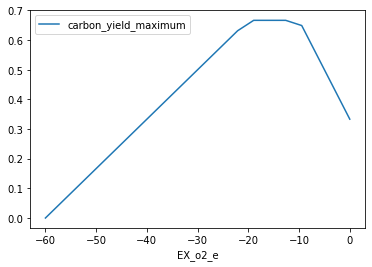

In [28]:
# the production envelope can be visualized in a plot as follows:
prod_env.plot(kind='line', x='EX_o2_e', y='carbon_yield_maximum');